In [1]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.integrate import simps
import yaml

# Plots

This notebook collects an extended analysis of the results of the RT computations.

## Analysis of the echo peaks for low fields

We analyze the properties of the echo peaks in function of $\tau$.

This analysis is useful to assess the efficiency of the echo signal retrieval and to compare the numerical results with
the ones derived from the analytical perturbation theory

In [2]:
file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e3_2e2.yaml'
file_pol = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/1ps-direct-decay-int_1e3_2e2/o-1ps-direct-decay-int_1e3_2e2.polarization'
pulse_str = 'int_1e3_2e2-omega_1.46-fwhm-100'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e3_1e3.yaml'
#file_pol = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/1ps-direct-decay-int_1e3_1e3/o-1ps-direct-decay-int_1e3_1e3.polarization'
#pulse_str = 'int_1e3_1e3-omega_1.46-fwhm-100'

eta = 4e-1

In [3]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [4]:
polarization = P.YamboOutputParser([file_pol])['polarization']
polarization.keys()

Parse file RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/1ps-direct-decay-int_1e3_2e2/o-1ps-direct-decay-int_1e3_2e2.polarization


dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [30]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']

In [6]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

# we compute the maximum of the pulse signal, of the echo signals and of the profile
px_ref_max = max(px_ref)
echo_max = {}
for t in tau:
    echo_max[t] = max(echo[t])
profile_max = max(profile[tau[0]])

# we compute the value of the time at which there is the max of the pulse and echo signal and of the profile
indt0 = np.argmax(px_ref)
t0 = time[indt0] # max of the pulse 
tmax_px_ref = time[np.argmax(px_ref)] # tmax of the pulse signal
t0 = time[np.argmax(profile[tau[0]])]
#tmax_echo = [time[np.argmax(echo[t])] for t in tau]
#tmax_profile = time[np.argmax(profile[tau[0]])] # max of the pulse profile
tmax_echo = {}
tmax_profile = {}
for t in tau:
    tmax_echo[t] = time[np.argmax(echo[t])]
    ind_max = argrelextrema(profile[t],np.greater,order=2)[0][1]
    tmax_profile[t] = time[ind_max]

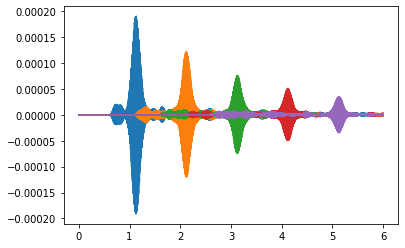

In [7]:
for t in tau:
    plt.plot(time,echo[t])

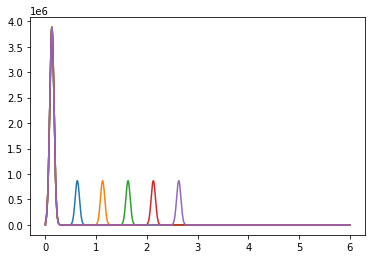

In [8]:
for t in tau:
    plt.plot(time,profile[t])

We build the expected exponential decay of the polarization, starting from the its peak

In [9]:
time_exp = time[indt0:]
exp_decay = px_ref_max*np.exp(-eta*(time_exp-time_exp[0]))

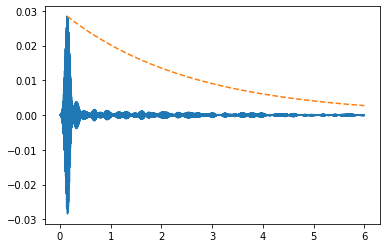

In [10]:
plt.plot(time,px_ref)
plt.plot(time_exp,exp_decay,linestyle='--')

We perform a gaussian fit of the first peak to estimate its properties

In [11]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [12]:
ind_px_ref_env = argrelextrema(px_ref,np.greater,order=3)[0] 
time_env = time[ind_px_ref_env]
px_ref_env = px_ref[ind_px_ref_env]

(0.0, 0.5)

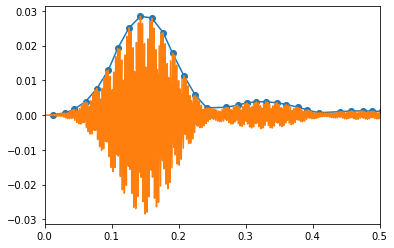

In [13]:
plt.plot(time_env,px_ref_env)
plt.scatter(time_env,px_ref_env)
plt.plot(time,px_ref)
plt.xlim(0,0.5)

In [14]:
sigma = 0.04
p0 = [px_ref_max,t0,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_env,p0=p0)
gauss_pars_ref

array([0.02885051, 0.14876858, 0.04326967])

(0.0, 0.5)

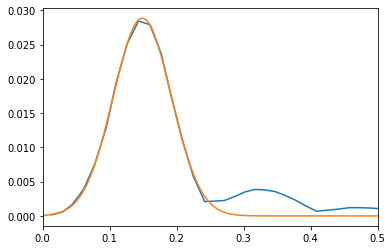

In [15]:
plt.plot(time_env,px_ref_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
plt.xlim(0,0.5)

The width of the peak is the same of the profile of the pulse and the maximum is located at 149 fs, that is
around 20 fs after the peak of the profile.

We define a procedure that perform a gaussian fit of the echo signal

In [16]:
gauss_pars = {}

for t in tau:
    signal = echo[t]
    # build the envelope of the signal
    ind_echo_env = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_echo_env]
    time_env = time[ind_echo_env]
    # perform the fit
    sigma = 0.100
    popt,pcov = curve_fit(gauss,time_env,values_env,p0=[echo_max[t],tmax_echo[t],sigma])
    gauss_pars[t] = popt
gauss_pars

{'0.5ps': array([1.88407806e-04, 1.12898349e+00, 7.97905426e-02]),
 '1ps': array([1.18214932e-04, 2.12099247e+00, 8.72655830e-02]),
 '1.5ps': array([7.25051541e-05, 3.12860230e+00, 9.16949381e-02]),
 '2ps': array([4.85521915e-05, 4.11902564e+00, 9.21676567e-02]),
 '2.5ps': array([3.37383203e-05, 5.12383982e+00, 8.71396797e-02])}

We can compute the distance between the max of the profile of the echo peak and the position of the max (according to a gaussian fit)
of the echo pulse

In [17]:
for t in tau:
    diffe = gauss_pars[t][1]-t0
    print(t,diffe)

0.5ps 1.0019834886460126
1ps 1.993992474246271
1.5ps 3.0016023023570986
2ps 3.992025638203386
2.5ps 4.996839821753017


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

We evaluate the echo efficiency according to the formula
$$
\theta_e(t) = \theta_p\lambda e^{-\eta(t-t_0)}
$$
where $\lambda$ is the efficiency of the echo retrieval and $t_0$ is the time position of the pulse peak.
Here $\theta_p$ and $\theta_e$ represent the _intensity_ of the pulse and echo signals.

We compute these quantities according to the formula

In [18]:
theta_p = np.sqrt(simps(px_ref**2,time))
theta_e = [np.sqrt(simps(echo[t]**2,time)) for t in tau]

In this case we can also use the gaussian fit to estimate the areas

In [40]:
#theta_p = np.sqrt(2*np.pi)*gauss_pars_ref[0]*gauss_pars_ref[2]
#theta_e = [np.sqrt(2*np.pi)*gauss_pars[t][0]*gauss_pars[t][2] for t in tau]

and we perform an exponential fit using the expected decay time

In [19]:
def monoExp(t, A):
    return A*np.exp(-eta*(t-tmax_px_ref))

In [20]:
A0 = 1e-4 # start with values near those we expect
tvals = [tmax_echo[t] for t in tau]
params, cv = curve_fit(monoExp, tvals, theta_e, A0)
A = params[0]
A

7.467568791581939e-05

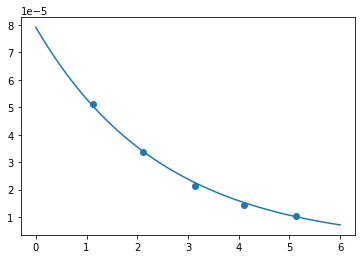

In [21]:
plt.scatter(tvals,theta_e)
plt.plot(time,monoExp(time,A))

The amplitude parameter $A$ is, by construction, the value of the signal at $t_0$, that
is at the time of the maximum of the pulse signal. From this parameter we can compute
the echo efficiency as

In [22]:
l = A/theta_p
l

0.012816177778759283

The two values are similar the general procedure can be used even when the signal has not a guassian shape.

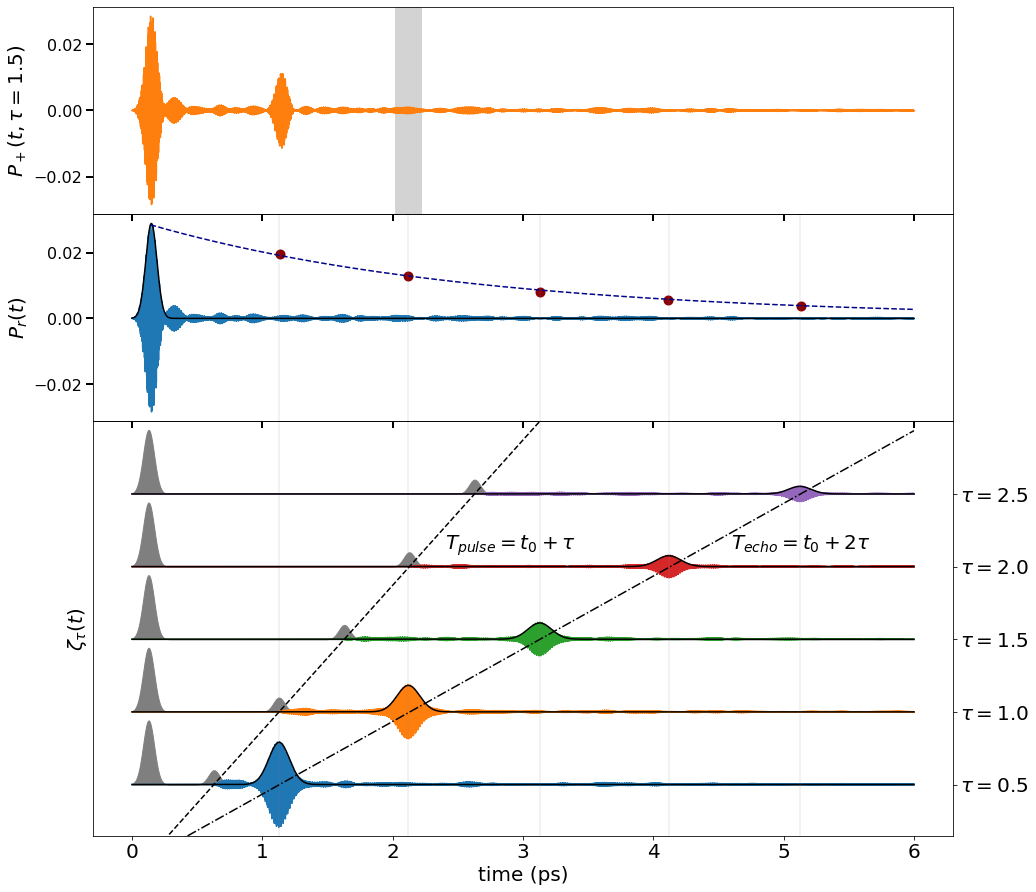

In [25]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
time_profile = np.array([tmax_profile[i] for i in tau])
time_echo = np.array([tmax_echo[t] for t in tau])
a_profile = 4*shift/(time_profile[-1]-time_profile[0])
b_profile = -a_profile*time_profile[0]
a_echo = 4*shift/(time_echo[-1]-time_echo[0])
b_echo = -a_echo*time_echo[0]
scatter_rescale = px_ref_max/A
ypos=0

fig, ax1 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,2]) 
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[0])

for t in tau:
    ax1.plot(time,ypos+echo[t]/echo_max[tau[0]]) #,color='tab:orange'
    ax1.fill_between(time,ypos+1.5*profile[t]/profile_max,ypos,color='tab:grey')
    ax1.plot(time,ypos+gauss(time,*gauss_pars[t])/echo_max[tau[0]],color='black',linestyle='-')
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
ax1.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax1.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

ax1.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax1.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('$\zeta_{\\tau}(t)$',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2.scatter(time_echo,scatter_rescale*np.array(theta_e),linewidth=4,color='darkred')
ax2.plot(time,px_ref)
ax2.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax2.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
for t in tau:
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax2.axhline(0,color='black',linestyle='-')
#ax2.set_xticks([])
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels([])
#ax2.set_yticks([])
ax2.tick_params(width=2,length=7,labelsize=16)
ax2.tick_params(width=2,length=7)
ax2.set_ylabel('$P_r(t)$',size=label_size)

ax3.plot(time,polarization['Pol_x'],color='tab:orange')
ax3.axvspan(gauss_pars['1ps'][1]-0.1, gauss_pars['1ps'][1]+0.1, color='lightgrey',fill=True)
#ax3.axvspan(gauss_pars['1.5ps'][1]-0.1, gauss_pars['1.5ps'][1]+0.1,ymin=0.5-0.05,ymax=0.5+0.05, color='lightgrey')
ax3.set_xticks([0,1,2,3,4,5,6])
ax3.set_xticklabels([])
#ax3.set_yticks([])
ax3.tick_params(width=2,length=7,labelsize=16)
ax3.set_ylabel('$P_+(t,\\tau=1.5)$',size=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%pulse_str,format='eps',bbox_inches = "tight")

In [24]:
# the shape is consistent with a delay 2*tau
a_echo/a_profile

0.5003752814610959

New proposal


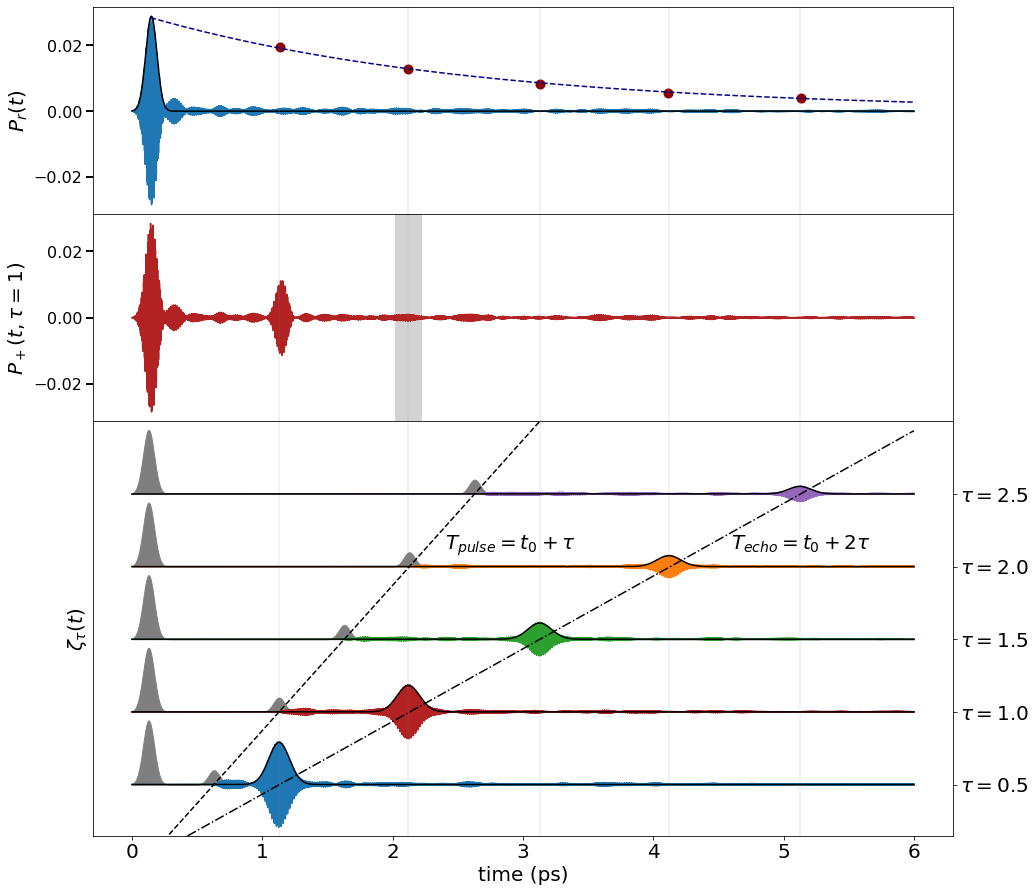

In [29]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
time_profile = np.array([tmax_profile[i] for i in tau])
time_echo = np.array([tmax_echo[t] for t in tau])
a_profile = 4*shift/(time_profile[-1]-time_profile[0])
b_profile = -a_profile*time_profile[0]
a_echo = 4*shift/(time_echo[-1]-time_echo[0])
b_echo = -a_echo*time_echo[0]
scatter_rescale = px_ref_max/A
ypos=0

fig, ax0 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# pr_ref panel
#ax0.scatter(time_echo,scatter_rescale*np.array(theta_e),linewidth=4,color='darkred')
ax0.plot(time,px_ref)
ax0.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax0.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
ax0.scatter(time_echo,scatter_rescale*np.array(theta_e),linewidth=4,color='darkred')
for t in tau:
    ax0.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax0.set_xticks([0,1,2,3,4,5,6])
ax0.set_xticklabels([])
ax0.tick_params(width=2,length=7,labelsize=16)
ax0.tick_params(width=2,length=7)
ax0.set_ylabel('$P_r(t)$',size=label_size)

# polarization panel
ax1.plot(time,polarization['Pol_x'],color='firebrick')
ax1.axvspan(gauss_pars['1ps'][1]-0.1, gauss_pars['1ps'][1]+0.1, color='lightgrey',fill=True)
for t in tau:
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels([])
ax1.tick_params(width=2,length=7,labelsize=16)
ax1.set_ylabel('$P_+(t,\\tau=1)$',size=label_size)

# echo panel
colors ={'0.5ps':'tab:blue','1ps':'firebrick','1.5ps':'tab:green','2ps':'tab:orange','2.5ps':'tab:purple'}
for t in tau:
    ax2.plot(time,ypos+echo[t]/echo_max[tau[0]],color=colors[t]) #,color='tab:orange'
    ax2.fill_between(time,ypos+1.5*profile[t]/profile_max,ypos,color='tab:grey')
    ax2.plot(time,ypos+gauss(time,*gauss_pars[t])/echo_max[tau[0]],color='black',linestyle='-')
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
ax2.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax2.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

ax2.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax2.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax2.set_xlabel('time (ps)',size=label_size)
ax2.set_ylabel('$\zeta_{\\tau}(t)$',size=label_size)
ax2.set_ylim(e_min,e_max)
ax2.set_yticks([shift*i for i in range(len(tau_disp))])
ax2.set_yticklabels(tau_disp,size=label_size)
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='major', labelsize=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%pulse_str,format='eps',bbox_inches = "tight")

## Polarization, echo peaks and carriers in the extended k region

In [35]:
#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e3_1e3_omega_1.58-fwhm_100.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/o-2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100.polarization'
#file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/o-2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100.carriers'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-int_1e3_1e3-omega_1.58-fwhm_100/ndb.RT_carriers'
#int_str = '1e3_1e3'

file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_int_1e5_1e5_omega_1.58-fwhm_100.yaml'
file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.polarization'
file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.carriers'
ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/ndb.RT_carriers'
int_str = '1e5_1e5'

#file = 'RT_Echo_k1000_kspan0.06/FixSymm/Results/echo_decay_int_1e5_1e5_omega_1.58-fwhm_10.yaml'
#file_pol = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10.polarization'
#file_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10.carriers'
#ndb_car = 'RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10/ndb.RT_carriers'
#int_str = '1e5_1e5'

eta = 4e-1

In [34]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [36]:
polarization = P.YamboOutputParser([file_pol])['polarization']
polarization.keys()

Parse file RT_Echo_k1000_kspan0.06/FixSymm/1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100/o-1ps-direct-int_1e5_1e5-omega_1.58-fwhm_100.polarization


dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [37]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']

In [88]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
pol_x = polarization['Pol_x']
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

In this case it is interesting to investigate the shape of the signal peak after the first pulse and
the associated echo signal.

To this aim we analyze a single echo signal

In [61]:
t = '1ps'

We build the envelope of the signals

In [81]:
ind_px_env = argrelextrema(pol_x,np.greater,order=3)[0] 
time_px_env = time[ind_px_env]
px_env = pol_x[ind_px_env]

In [83]:
ind_echo_env = argrelextrema(echo[t],np.greater,order=3)[0] 
time_echo_env = time[ind_echo_env]
echo_env = echo[t][ind_echo_env]

(0.0, 3.0)

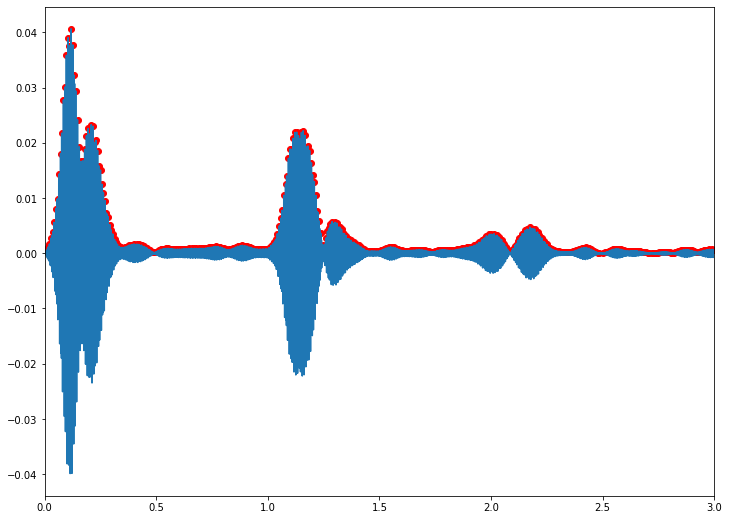

In [82]:
plt.figure(figsize=(12,9))
plt.plot(time,polarization['Pol_x'])
plt.scatter(time_px_env,px_env,color='red')
plt.xlim(0,3)

(0.0, 4.0)

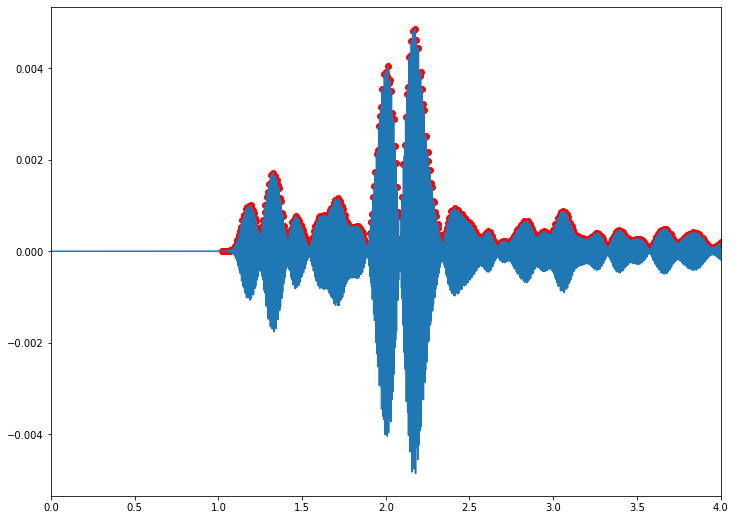

In [87]:
plt.figure(figsize=(12,9))
plt.plot(time,echo[t])
plt.scatter(time_echo_env,echo_env,color='red')
plt.xlim(0,4)

We compute the time position of the various peaks

In [95]:
ind_px_max = argrelextrema(px_env,np.greater,order=4)[0]
time_px_env[ind_px_max]

array([0.118, 0.208, 0.4  , 0.553, 0.658, 0.766, 0.885, 1.158, 1.288,
       1.55 , 1.681, 1.782, 2.013, 2.174, 2.427, 2.56 , 2.643, 2.774,
       2.872, 2.978, 3.077, 3.203, 3.346, 3.429, 3.527, 3.589, 3.659,
       3.751, 3.785, 3.906, 4.132, 4.323, 4.437, 4.527, 4.633, 4.723,
       4.944, 5.055, 5.183, 5.344, 5.501, 5.62 , 5.75 , 5.893, 5.988])

we observe the the signal after the first pulse is structured with a double peaks
located at 118 and 208 fs. The signal after the echo pulse has peaks located at
1.158 and 1.288.

In [96]:
ind_echo_max = argrelextrema(echo_env,np.greater,order=4)[0]
time_echo_env[ind_echo_max]

array([1.193, 1.328, 1.463, 1.717, 1.828, 2.013, 2.174, 2.411, 2.609,
       2.702, 2.848, 2.944, 3.061, 3.263, 3.395, 3.503, 3.661, 3.838,
       4.046, 4.173, 4.263, 4.374, 4.462, 4.557, 4.702, 4.902, 5.037,
       5.159, 5.454, 5.639, 5.74 , 5.846])

the echo peaks are located at 2.013 and 2.174

In [ ]:
###################################################################################à

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [133]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']
echo_peak_vals = [1.,2.,3.,4.,5.]

In [134]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

(0.0, 0.1)

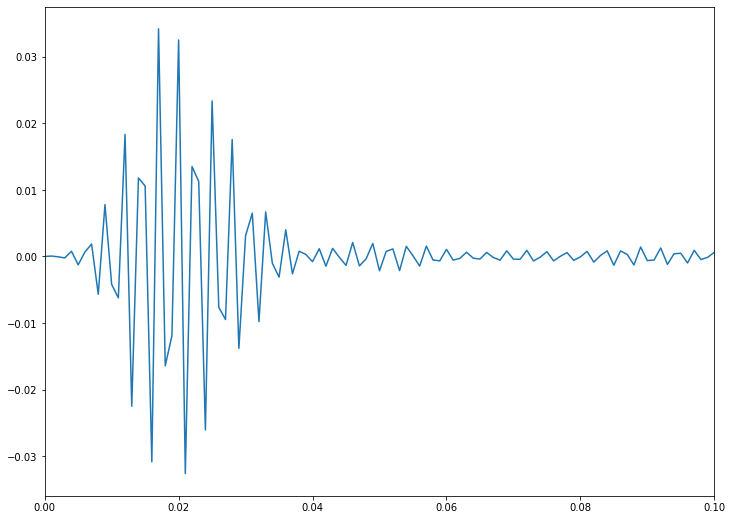

In [138]:
plt.figure(figsize=(12,9))
plt.plot(time,px_ref)
plt.xlim(0,0.1)

(0.7, 1.3)

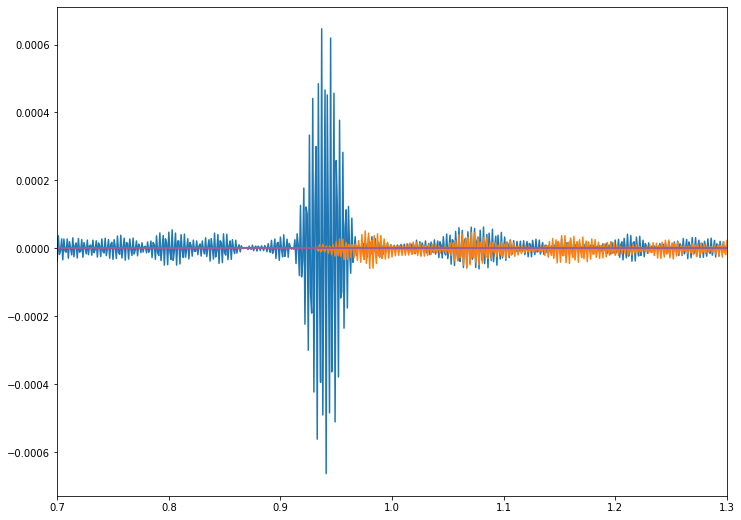

In [137]:
plt.figure(figsize=(12,9))
for t in tau:
    plt.plot(time,echo[t])
plt.xlim(0.7,1.3)

We analyze the echo efficiency retrivial without using the guassian fit of the peak. 

To this scope we compute the time integral of the square of the polarization (that should be proportional
to the emitted radiation)

In [92]:
from scipy.integrate import simps

In [93]:
inte = []
for t in tau:
    inte.append(simps(echo[t]**2,x=time))

In [94]:
exp_decay = inte[0]*np.exp(-2*eta*(time-echo_peak_vals[0]))

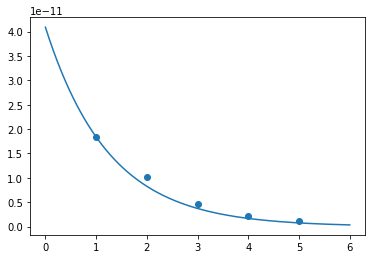

In [95]:
plt.scatter(echo_peak_vals,inte)
plt.plot(time,exp_decay)

We analyze the carriers and the non-equilibrium occupation level

In [139]:
output = P.YamboOutputParser([file_pol,file_car])
polarization = output['polarization']['Pol_x']
carriers = output['carriers']['dne']

Parse file RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10.polarization
Parse file RT_Echo_k1000_kspan0.06/FixSymm/2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10/o-2ps-direct-decay-int_1e5_1e5-omega_1.58-fwhm_10.carriers


We also plot the carriers

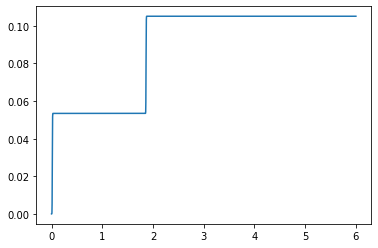

In [140]:
plt.plot(time,carriers)
#plt.plot(time,5*polarization)

We analyze the RT_Carriers

In [141]:
occ = U.get_variable_from_db(ndb_car,'RT_carriers_delta_f')
ntime,nstates = occ.shape
ntime,nstates

(121, 83895)

In [142]:
time_ndb = np.linspace(0,6,ntime)

In [143]:
rt_bands = 7

In [144]:
def fetch_band_indexes(nstates,rt_bands,band):
    numk = int(nstates/rt_bands)
    indexes = [k*rt_bands+band for k in range(numk)]
    return indexes

In [145]:
c1_ind = fetch_band_indexes(nstates,rt_bands,3)
c2_ind = fetch_band_indexes(nstates,rt_bands,4)
c3_ind = fetch_band_indexes(nstates,rt_bands,5)
c4_ind = fetch_band_indexes(nstates,rt_bands,6)


c1 = occ[:,c1_ind]
c2 = occ[:,c2_ind]
c3 = occ[:,c3_ind]
c4 = occ[:,c4_ind]

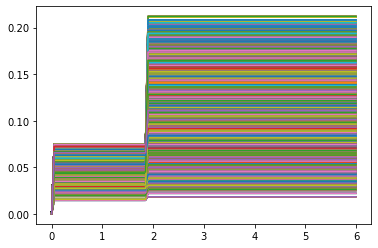

In [146]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c1[:,k])

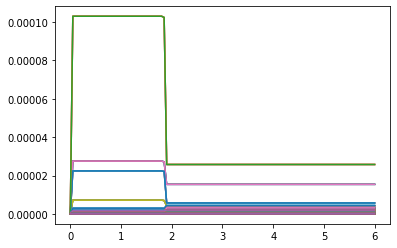

In [147]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c2[:,k])

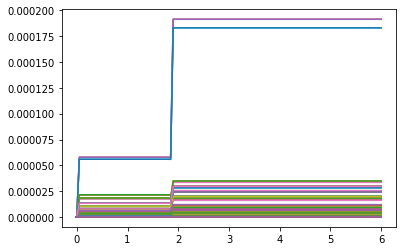

In [148]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c3[:,k])

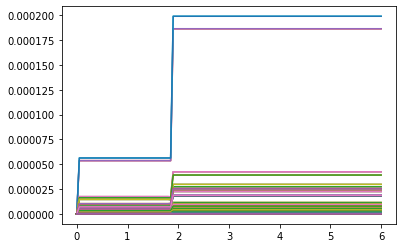

In [149]:
for k in range(len(c1[0])):
    plt.plot(time_ndb,c4[:,k])

In [25]:
############################################################################

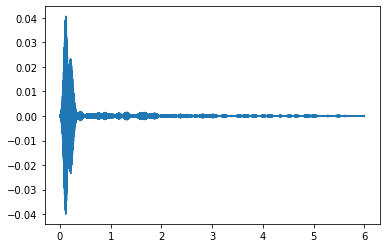

In [26]:
plt.plot(time,px_ref)

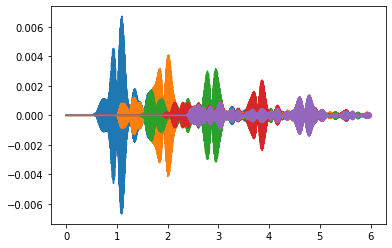

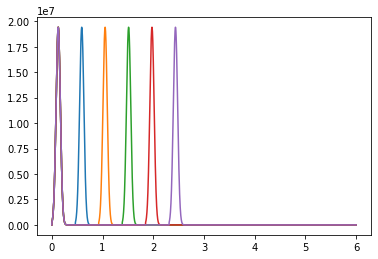

In [8]:
for t in tau:
    plt.plot(time,profile[t])

In [9]:
ind_max = argrelextrema(profile['2ps'],np.greater,order=2)[0]
profile['2ps'][ind_max][0]/profile['2ps'][ind_max][1]

1.000001823850217

We define a procedure that perform a gaussian fit of the echo signal

In [11]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [12]:
gauss_pars = {}

for t,p in zip(tau,echo_peak_vals):
    signal = echo[t]
    # build the envelope of the signal
    ind_max = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_max]
    time_env = time[ind_max]
    # perform the fit
    mean = p
    sigma = 0.100
    popt,pcov = curve_fit(gauss,time_env,values_env,p0=[1,mean,sigma])
    gauss_pars[t] = popt
gauss_pars

{'0.5ps': array([0.0042904 , 1.05051223, 0.16649291]),
 '1ps': array([0.0024593 , 1.89899926, 0.28647974]),
 '1.5ps': array([2.26946203e-03, 2.86867065e+00, 1.81319893e-01]),
 '2ps': array([1.64049777e-03, 3.80246660e+00, 1.65027403e-01]),
 '2.5ps': array([1.00164433e-03, 4.70946596e+00, 1.97422370e-01])}

We perform the gaussian fit of the echo signal in the polarization $P_+$

In [13]:
start_ind = 2500
peak_time = time[start_ind:]
peak_signal = polarization['Pol_x'][start_ind:]
ind_max = argrelextrema(peak_signal,np.greater,order=3)[0]
values_env = peak_signal[ind_max]
time_env = time[ind_max]
# perform the fit
mean = 4
sigma = 0.100
popt,pcov = curve_fit(gauss,time_env,values_env,p0=[1,mean,sigma])
gauss_pars_peak = popt
gauss_pars_peak

array([8.60288300e-04, 1.08112107e+00, 7.02196491e-01])

We plot polarization $P_+$ and the relative echo peak

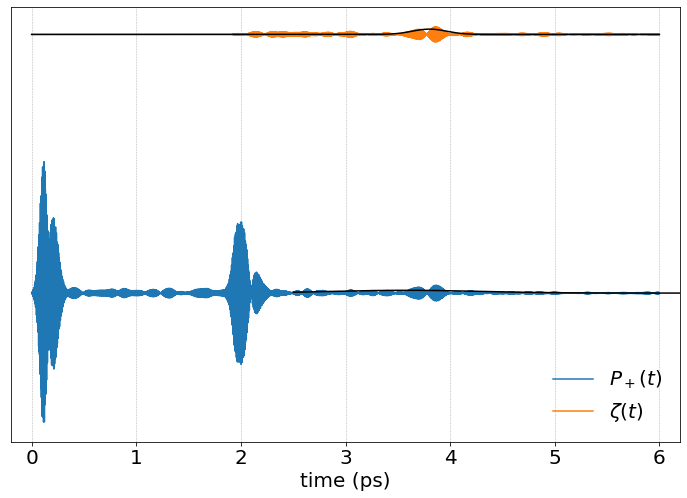

In [14]:
tval = '2ps'
label_size = 20
shift = 8e-2

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(time,polarization['Pol_x'],label='$P_+(t)$')
ax1.plot(peak_time[0]+time,gauss(time,*gauss_pars_peak),color='black',linestyle='-')
ax1.plot(time,shift+echo[tval],label='$\zeta(t)$')
ax1.plot(time,shift+gauss(time,*gauss_pars[tval]),color='black',linestyle='-')
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.grid(axis='x',linestyle='--',linewidth=0.5)
ax1.legend(loc='best',fontsize=label_size,frameon=False)
ax1.set_xlim(-0.2,6.2)
ax1.set_xlabel('time (ps)',size=label_size)

#plt.savefig(fname='Plot/echo_vs_polarization_%s.eps'%int_str,format='eps',bbox_inches = "tight")

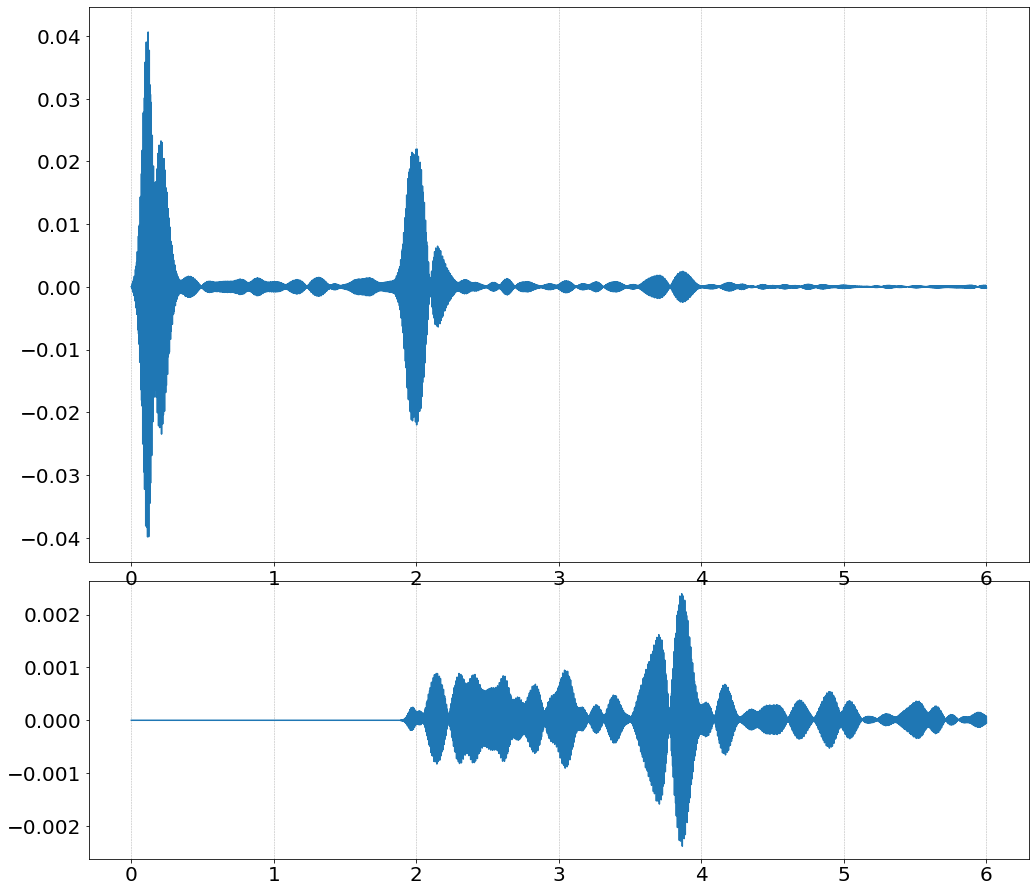

In [18]:
tval = '2ps'
label_size = 20

fig, ax1 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])

ax1.plot(time,echo[tval],label='$\zeta(t)$')
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.grid(axis='x',linestyle='--',linewidth=0.5)
#ax1.legend(loc='best',fontsize=label_size,frameon=False)

ax2.plot(time,polarization['Pol_x'],label='$P_+(t)$')
ax2.tick_params(axis='both', which='major', labelsize=label_size)
ax2.grid(axis='x',linestyle='--',linewidth=0.5)

plt.tight_layout(pad=-0.7)